In [ ]:
import ee
import os
import time
from pathlib import Path
import requests
from PIL import Image
import numpy as np
from io import BytesIO
from dotenv import load_dotenv

print('imported')

imported


In [ ]:
# ==============================
# TOPIC 1: PROJECT CONFIGURATION
# ==============================

PROJECT_ID = ""
OUTPUT_DIR = "ndvi_dataset"
NUM_IMAGES = 50

SCALE = 10                 # 10m is best for vegetation & urban studies
MAX_CLOUD_PERCENT = 20     # Maximum cloud cover

START_YEAR = 2015          # Study period
END_YEAR = 2024

# Region of Interest (ROI)
# Example: Sydney, Australia (urban + forest edge)
ROI_COORDS = [
    150.8, -34.1,   # min lon, min lat
    151.3, -33.6    # max lon, max lat
]

print("Topic 1: Configuration loaded successfully.")


Topic 1: Configuration loaded successfully.


In [ ]:
# ==============================
# TOPIC 2: EARTH ENGINE INIT
# ==============================

print("Initializing Earth Engine...")
try:
    ee.Initialize(project=PROJECT_ID)
    print("Earth Engine initialized successfully.")

except Exception as e:
    print("Authentication required. Starting authentication...")
    ee.Authenticate()
    ee.Initialize(project=PROJECT_ID)
    print("Earth Engine authenticated and initialized successfully.")


Initializing Earth Engine...
Earth Engine initialized successfully.


In [ ]:
# QUICK TEST (Important)
print("EE test:", ee.Number(1).add(1).getInfo())

EE test: 2


In [ ]:
# ==============================
# TOPIC 3A: ROI GEOMETRY
# ==============================

# Create Earth Engine Rectangle Geometry
roi = ee.Geometry.Rectangle(ROI_COORDS)

print("ROI geometry created successfully.")
print("ROI bounds:", roi.bounds().getInfo())

# ==============================
# TOPIC 3B: FOLDER SETUP
# ==============================

from pathlib import Path

# Define folder paths
BASE_DIR = Path(OUTPUT_DIR)
IMAGE_DIR = BASE_DIR / "images"
METADATA_DIR = BASE_DIR / "metadata"
LOG_DIR = BASE_DIR / "logs"

# Create directories if they don't exist
for directory in [BASE_DIR, IMAGE_DIR, METADATA_DIR, LOG_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("Output folder structure created:")
print(" -", IMAGE_DIR)
print(" -", METADATA_DIR)
print(" -", LOG_DIR)


ROI geometry created successfully.
ROI bounds: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[150.8, -34.10025320648134], [151.3, -34.10025320648134], [151.3, -33.59999999999998], [150.8, -33.59999999999998], [150.8, -34.10025320648134]]]}
Output folder structure created:
 - ndvi_dataset/images
 - ndvi_dataset/metadata
 - ndvi_dataset/logs


In [ ]:
print("ROI area (sq km):", roi.area().divide(1e6).getInfo())


ROI area (sq km): 2567.134948648332


In [ ]:
# ==============================
# SAMPLE DATA CONFIG   (Purpose: visual understanding ✔️)
# ==============================

SAMPLE_DIR = 'sample_data'
RGB_DIR = f'{SAMPLE_DIR}/rgb'

NUM_SAMPLE_IMAGES = 50
SCALE_SAMPLE = 60          # LOW QUALITY (60m)
CLOUD_THRESHOLD = 20       # Reasonable balance

from pathlib import Path

Path(RGB_DIR).mkdir(parents=True, exist_ok=True)
print("Sample folders ready.")

# ==============================
# SAMPLE SENTINEL-2 COLLECTION
# ==============================

def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud = qa.bitwiseAnd(1 << 10).eq(0)
    cirrus = qa.bitwiseAnd(1 << 11).eq(0)
    return image.updateMask(cloud.And(cirrus))

s2_sample = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(roi)
    .filterDate('2019-01-01', '2024-12-31')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_THRESHOLD))
    .map(mask_s2_clouds)
    .sort('system:time_start')
)

print("Total available images:", s2_sample.size().getInfo())

s2_sample = s2_sample.limit(NUM_SAMPLE_IMAGES)

# RGB Download Function
import requests

def download_rgb_sample(image, index):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

    rgb = image.select(['B4', 'B3', 'B2']).visualize(
        min=0,
        max=3000,
        bands=['B4', 'B3', 'B2']
    )

    url = rgb.getThumbURL({
        'region': roi,
        'dimensions': 512,   # LOW resolution
        'format': 'png'
    })

    filename = f"{RGB_DIR}/sample_{index:02d}_{date}.png"

    r = requests.get(url, timeout=120)
    if r.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(r.content)
        print(f"✓ Downloaded {filename}")
    else:
        print(f"✗ Failed {date}")

# download loop
sample_list = s2_sample.toList(NUM_SAMPLE_IMAGES)

for i in range(NUM_SAMPLE_IMAGES):
    img = ee.Image(sample_list.get(i))
    download_rgb_sample(img, i)


Sample folders ready.
Total available images: 476
✓ Downloaded sample_data/rgb/sample_00_2019-01-01.png
✓ Downloaded sample_data/rgb/sample_01_2019-01-05.png
✓ Downloaded sample_data/rgb/sample_02_2019-01-11.png
✓ Downloaded sample_data/rgb/sample_03_2019-01-15.png
✓ Downloaded sample_data/rgb/sample_04_2019-01-15.png
✓ Downloaded sample_data/rgb/sample_05_2019-01-16.png
✓ Downloaded sample_data/rgb/sample_06_2019-01-21.png
✓ Downloaded sample_data/rgb/sample_07_2019-01-25.png
✓ Downloaded sample_data/rgb/sample_08_2019-01-25.png
✓ Downloaded sample_data/rgb/sample_09_2019-01-26.png
✓ Downloaded sample_data/rgb/sample_10_2019-02-09.png
✓ Downloaded sample_data/rgb/sample_11_2019-02-10.png
✓ Downloaded sample_data/rgb/sample_12_2019-02-19.png
✓ Downloaded sample_data/rgb/sample_13_2019-02-19.png
✓ Downloaded sample_data/rgb/sample_14_2019-03-02.png
✓ Downloaded sample_data/rgb/sample_15_2019-03-11.png
✓ Downloaded sample_data/rgb/sample_16_2019-03-22.png
✓ Downloaded sample_data/rgb/sam

In [ ]:
# ==============================
# TOPIC 4.1: STUDY TIME RANGE
# ==============================

START_DATE = '2015-01-01'
END_DATE   = '2024-12-31'

print("Study period:", START_DATE, "to", END_DATE)

# ==============================
# TOPIC 4.2: SENTINEL-2 CLOUD MASK
# ==============================

def mask_s2_clouds(image):
    qa = image.select('QA60')

    cloud_bit  = 1 << 10
    cirrus_bit = 1 << 11

    mask = qa.bitwiseAnd(cloud_bit).eq(0).And(
           qa.bitwiseAnd(cirrus_bit).eq(0))

    return (
        image.updateMask(mask)
             .divide(10000)  # Scale reflectance to 0–1
             .copyProperties(image, ['system:time_start'])
    )

# ==============================
# TOPIC 4.3: SENTINEL-2 COLLECTION
# ==============================

CLOUD_PERCENT = 10   # YES, this is correct for vegetation studies

s2_collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(roi)
    .filterDate(START_DATE, END_DATE)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_PERCENT))
    .map(mask_s2_clouds)
    .sort('system:time_start')
)

print("Total clean images:", s2_collection.size().getInfo())

# ==============================
# TOPIC 4.4: COLLECTION CHECK
# ==============================

first_image = ee.Image(s2_collection.first())

print("Bands:", first_image.bandNames().getInfo())
print("Date:",
      ee.Date(first_image.get('system:time_start'))
        .format('YYYY-MM-dd').getInfo())


Study period: 2015-01-01 to 2024-12-31
Total clean images: 374
Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']
Date: 2016-06-29


In [ ]:
# ==============================
# TOPIC 5.1: LIMIT TO 100 IMAGES
# ==============================

MAX_IMAGES = 100

s2_limited = s2_collection.limit(MAX_IMAGES)

print("Images selected for NDVI:", s2_limited.size().getInfo())

# ==============================
# TOPIC 5.2: NDVI FUNCTION
# ==============================

def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# ==============================
# TOPIC 5.3: APPLY NDVI
# ==============================

s2_ndvi = s2_limited.map(add_ndvi)

print("NDVI calculation complete.")

# ==============================
# TOPIC 5.4: VALIDATION
# ==============================

sample_image = ee.Image(s2_ndvi.first())

print("Bands:", sample_image.bandNames().getInfo())

ndvi_stats = sample_image.select('NDVI').reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=10,
    maxPixels=1e9
)

print("NDVI Min/Max:", ndvi_stats.getInfo())


Images selected for NDVI: 100
NDVI calculation complete.
Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE', 'NDVI']
NDVI Min/Max: {'NDVI_max': 1, 'NDVI_min': -1}


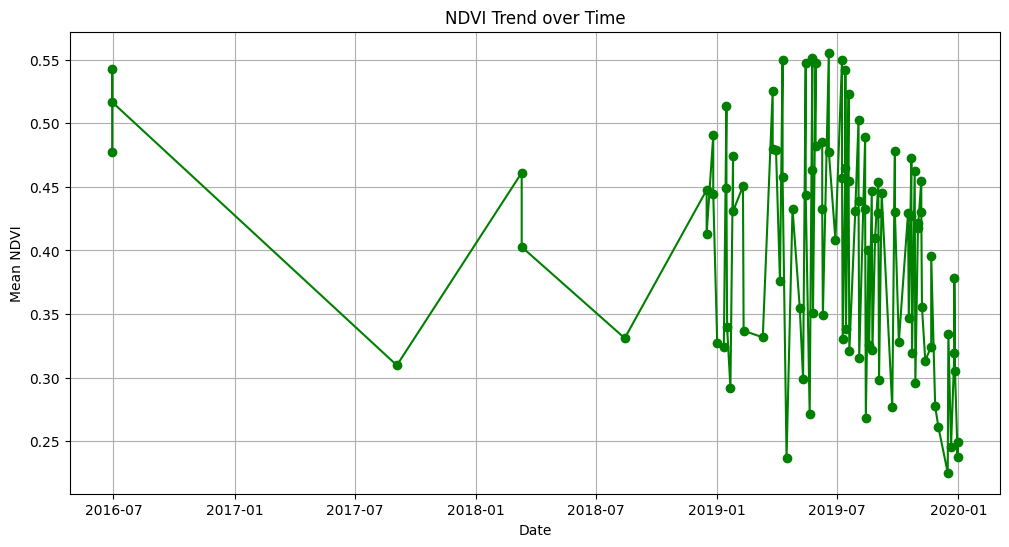

NDVI time series saved as 'ndvi_time_series.csv'
✅ NDVI time series extracted and plotted successfully!
Number of images processed: 100
Date range: 2016-06-29 00:00:00 to 2019-12-31 00:00:00


In [ ]:
# ==============================
# TOPIC 6: NDVI TIME SERIES & TREND
# ==============================

import pandas as pd
import matplotlib.pyplot as plt

# Function to extract mean NDVI for each image
def get_mean_ndvi(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    mean_dict = image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        'date': date,
        'NDVI': mean_dict.get('NDVI')
    })

# Map over the NDVI collection to get mean NDVI per image
ndvi_features = s2_ndvi.map(get_mean_ndvi)

# Convert to a FeatureCollection
ndvi_fc = ee.FeatureCollection(ndvi_features)

# Get the data as a list of dictionaries
ndvi_list = ndvi_fc.getInfo()['features']

# Parse into a DataFrame for plotting
ndvi_data = []
for f in ndvi_list:
    props = f['properties']
    ndvi_data.append({
        'date': props['date'],
        'NDVI': props['NDVI']
    })

df_ndvi = pd.DataFrame(ndvi_data)
df_ndvi['date'] = pd.to_datetime(df_ndvi['date'])
df_ndvi = df_ndvi.sort_values('date')

# ==============================
# PLOT NDVI TREND
# ==============================
plt.figure(figsize=(12,6))
plt.plot(df_ndvi['date'], df_ndvi['NDVI'], marker='o', linestyle='-', color='green')
plt.title('NDVI Trend over Time')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.grid(True)
plt.show()

# ==============================
# OPTIONAL: SAVE TO CSV
# ==============================
df_ndvi.to_csv('ndvi_time_series.csv', index=False)
print("NDVI time series saved as 'ndvi_time_series.csv'")

# ==============================
# SUMMARY
# ==============================
print("✅ NDVI time series extracted and plotted successfully!")
print("Number of images processed:", len(df_ndvi))
print("Date range:", df_ndvi['date'].min(), "to", df_ndvi['date'].max())


In [ ]:
# Folder to save sample images
OUTPUT_DIR = 'sample_data'
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/rgb_images", exist_ok=True)

# ROI (same as before)
roi = ee.Geometry.Rectangle([82.75, 22.95, 82.85, 23.05])

# Image collection (Sentinel-2, low cloud)
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(roi) \
    .filterDate('2018-01-01', '2025-01-01') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .sort('system:time_start') \
    .limit(50)

# Function to download PNG
def download_rgb_image(image, region, filename):
    rgb_vis = image.select(['B4','B3','B2']).visualize(
        min=0, max=3000, bands=['B4','B3','B2']
    )
    url = rgb_vis.getThumbURL({
        'region': region,
        'dimensions': 1024,
        'format': 'png'
    })
    response = requests.get(url, timeout=300)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded: {filename}")
    else:
        print(f"Failed: {filename}")

# Download loop
image_list = s2_collection.toList(50)
for i in range(50):
    image = ee.Image(image_list.get(i))
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    filename = f"{OUTPUT_DIR}/rgb_images/sample_{date}.png"
    download_rgb_image(image, roi, filename)
    time.sleep(1)  # to avoid request issues

print("✅ Sample images downloaded to 'sample_data/rgb_images'")

